# Read and plot the MECMAUS model

Load packages

In [10]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors

import xarray as xr

import shapely
import shapely.plotting

import geopandas as gpd

import cartopy.crs as ccrs
import cartopy.feature as cf

import cmcrameri.cm as cmc

%matplotlib inline

### Auxiliary routines

In [11]:
def plot_base_map(mask_offshore = True, map_extent = [112, 155, -44, -10], 
                  ccrs_proj=ccrs.PlateCarree()):

    # Create basemap
    fig = plt.figure(figsize=(12, 7))
    # Mercator projection
    ax = fig.add_subplot(1, 1, 1, projection=ccrs_proj)
    
    ax.add_feature(cf.STATES, edgecolor='gray', linewidth=0.5, linestyle='--')    
    ax.add_feature(cf.BORDERS, color = 'black', linewidth = 0.5)
    ax.coastlines(color = 'black', linewidth=0.5)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.5, color='gray', rotate_labels=False,
                      x_inline=False, y_inline=False)
    
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlabel_style = {'size': 16}
    gl.ylabel_style = {'size': 16}

    # Plot survey area
    if mask_offshore:
        shapely.plotting.plot_polygon(model_mask_polygon, ax=ax, fc='white', ec='k', 
                                      alpha=1, zorder=5, add_points=False, transform=ccrs.PlateCarree())
    
    ax.set_extent(map_extent) 
    
    return fig, ax, gl

def plot_depth_grid( lat_edges, lon_edges, rho_grid, rho_range=[1, 5000] ):
    
    fig, ax, gl = plot_base_map()   

    pm = ax.pcolormesh(lon_edges, lat_edges, rho_grid, shading='flat', 
                      norm = mpl.colors.LogNorm(vmin=rho_range[0], vmax=rho_range[1]),
                      cmap = cmc.batlow_r, transform=ccrs.PlateCarree())

    cbar = fig.colorbar(pm, ax = ax, pad = 0.08, shrink=0.5, orientation = "horizontal" )
    cbar.set_label(r"Resistivity [$\Omega$m]", fontsize=20)
    cbar.ax.tick_params(labelsize=20)
    
    return fig, ax, gl

### Read in data using xarray

Open file and print header

In [12]:
ds = xr.open_dataset("MECMAUS-2025.nc") 

for k, v in ds.attrs.items():
    print(f"{k}: {v}")

print(ds.info())

title: Electrical resistivity on regular lon/lat/depth grid
summary: Resistivity (Ohm m) interpolated from hexahedral spherical octree mesh onto a regular grid.
Conventions: CF-1.8
history: 2025-09-26T17:00:21Z: created NetCDF
creator_name: Alexander Grayver
creator_website: www.agrayver.com
authors: Alexander Grayver
contact: www.agrayver.com
references: The electrical conductivity model of the Australian lithosphere, in preparation; doi:10.1234/to-be-added
license: CC-BY 4.0
project: MECMAUS
xarray.Dataset {
dimensions:
	depth = 31 ;
	lat = 450 ;
	lon = 429 ;
	nv = 2 ;
	depth_edge = 32 ;
	lat_edge = 451 ;
	lon_edge = 430 ;

variables:
	float64 resistivity(depth, lat, lon) ;
		resistivity:long_name = Electrical resistivity ;
		resistivity:units = ohm m ;
		resistivity:cell_methods = depth: point lat: point lon: point ;
	float64 depth_bnds(depth, nv) ;
	float64 lat_bnds(lat, nv) ;
	float64 lon_bnds(lon, nv) ;
	float64 depth(depth) ;
		depth:standard_name = depth ;
		depth:units = km ;


Visualize active domain/survey area

In [13]:
print("Model is sampled at these depths:", ds.depth)

Model is sampled at these depths: <xarray.DataArray 'depth' (depth: 31)> Size: 248B
array([  0.625,   1.875,   3.125,   4.375,   6.25 ,   8.75 ,  12.5  ,  17.5  ,
        22.5  ,  27.5  ,  32.5  ,  37.5  ,  42.5  ,  47.5  ,  52.5  ,  57.5  ,
        63.75 ,  71.25 ,  78.75 ,  86.25 ,  95.   , 105.   , 115.   , 125.   ,
       140.   , 160.   , 185.   , 215.   , 255.   , 305.   , 380.   ])
Coordinates:
  * depth    (depth) float64 248B 0.625 1.875 3.125 4.375 ... 255.0 305.0 380.0
Attributes:
    standard_name:  depth
    units:          km
    positive:       down
    axis:           Z
    bounds:         depth_bnds


In [14]:
# CONUS polygon
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Select Australia
au = world[world['name'] == 'Australia']
shoreline_poly = gpd.GeoSeries(shapely.ops.unary_union([au.iloc[0]['geometry'].geoms[0:2]]))[0]

bb = shapely.box(xmin = 100, xmax = 160, ymin = -60, ymax = -5)
model_mask_polygon = bb.difference(shoreline_poly)

/tmp/ipykernel_527352/1659494834.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


Visualize electrical resistivity at selected depths

/home/ag/miniconda3/envs/gofem/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/ag/miniconda3/envs/gofem/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/ag/miniconda3/envs/gofem/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


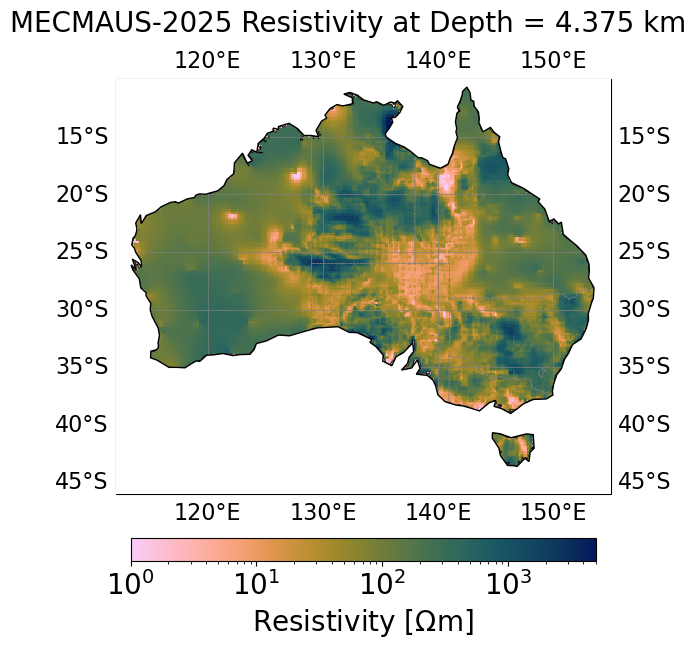

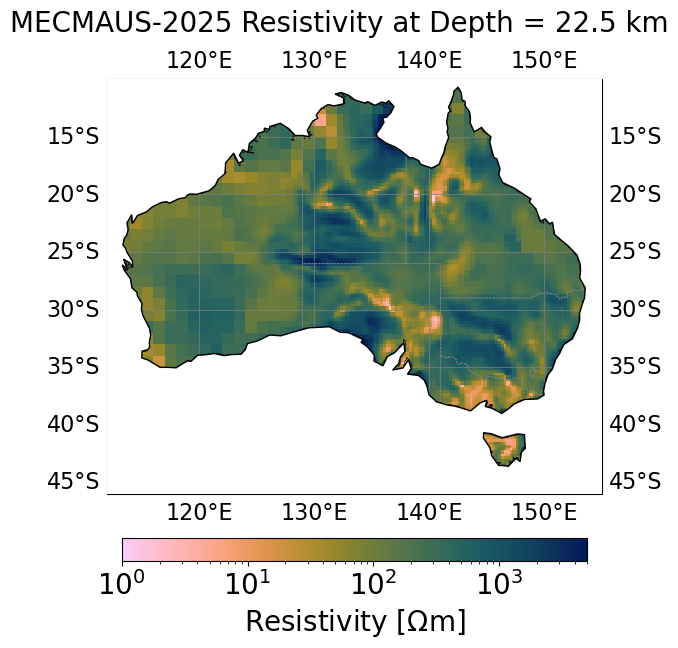

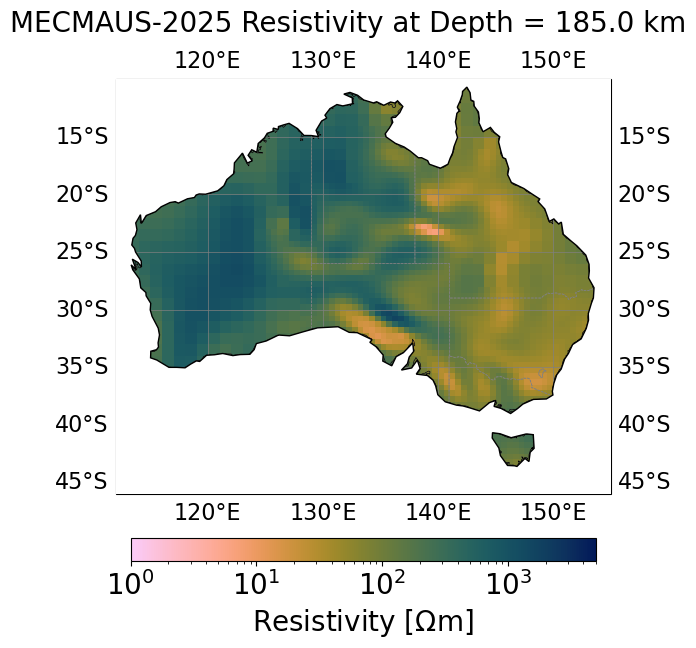

In [15]:
for target_depth in [4.375, 22.5, 185.0]:  # in km

    slice = ds.resistivity.sel(depth=target_depth, method="nearest")  # (lat, lon)

    fig, ax, gl = plot_depth_grid( ds.lat_edge, ds.lon_edge, slice, rho_range=[1, 5000] )

    fig.suptitle(f"MECMAUS-2025 Resistivity at Depth = {target_depth} km", fontsize=20)

    #fig.savefig(f"MECMAUS-2025_depth_{target_depth}km.png", dpi=300, bbox_inches='tight')

ds.close()